In [1]:
import gspread
import pandas as pd
import re
from gspread_dataframe import get_as_dataframe
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import numpy as np
import textwrap
import seaborn as sns

In [2]:
plt.rcParams.update(
    {
        "font.size": 14,  # 默认字体大小
        "axes.titlesize": 16,  # 标题字体
        "axes.labelsize": 14,  # 坐标轴标签
        "xtick.labelsize": 12,  # x 轴刻度
        "ytick.labelsize": 12,  # y 轴刻度
        "legend.fontsize": 12,  # 图例字体
    }
)

In [3]:
CREDENTIALS_JSON = "../rm4mt-463314-3ce1280ee29c.json"
sheet_urls = [
    "https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1LHsMMvKhTEgagmZKQl7ax1H4BJyDBImYMbeE8sNPjJw/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1PRIfwNA4l2TG3oMFlgM8LIGuxvCH8prfgEvbGMDhqIY/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/11WAU3v3uKN1wV3G7crmGDyo3u4QX4aGlhWpQN7tn9As/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1pSBxhdqGvu2I5z_8C6l6pePV-IkIl31MM83Py_ILRqU/edit?usp=sharing",
]

In [4]:
gc = gspread.service_account(filename=CREDENTIALS_JSON)
all_data = {}

In [5]:
for sheet_url in sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how="all").dropna(axis=1, how="all")
        ws_data[worksheet.title] = df
        time.sleep(2)
    all_data[sheet_url] = ws_data

Reading Sheet: https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing


In [6]:
def split_by_metric(all_data):
    dfs_by_metric = defaultdict(list)  # metric: list of rows

    for sheet_url, ws_dict in all_data.items():
        for ws_name, df in ws_dict.items():
            match = re.match(
                r"(.+?)_((comet_score|comet_kiwi_score|grb|grf|gea_100|gea_5|thinking_length))$",
                ws_name,
            )
            if not match:
                continue
            task = match.group(1)
            metric = match.group(2)
            # Check must have model & lang_pair
            if not {"model", "lang_pair"}.issubset(df.columns):
                continue
            # Budget Column - include numeric columns and "low", "high"
            numeric_cols = [
                col
                for col in df.columns
                if isinstance(col, (int, float))
                or (isinstance(col, str) and col.isdigit())
            ]
            text_budget_cols = [col for col in df.columns if col in ["low", "high"]]
            budget_cols = sorted(numeric_cols, key=lambda x: int(x)) + text_budget_cols

            for _, row in df.iterrows():
                model = row["model"]
                lang_pair = row["lang_pair"]
                for budget in budget_cols:
                    val = row[budget]
                    if pd.isna(val):
                        continue
                    # Handle budget value - keep as string for "low"/"high", convert to int for numeric
                    budget_val = budget if budget in ["low", "high"] else int(budget)
                    dfs_by_metric[metric].append(
                        {
                            "model": model,
                            "task": task,
                            "metric": metric,
                            "lang_pair": lang_pair,
                            "budget": budget_val,
                            "score": float(val),
                        }
                    )

    # To DataFrame
    for metric in dfs_by_metric:
        dfs_by_metric[metric] = pd.DataFrame(dfs_by_metric[metric])

    return dfs_by_metric


dfs_by_metric = split_by_metric(all_data)

In [7]:
gea_100_df = dfs_by_metric["gea_100"]
gea_5_df = dfs_by_metric["gea_5"]

In [8]:
drt_gea_100_df = gea_100_df[
    (gea_100_df["lang_pair"] == "Avg")
    & (gea_100_df["model"].isin(["DRT-7B", "DRT-8B", "DRT-14B"]))
]
drt_gea_5_df = gea_5_df[
    (gea_5_df["lang_pair"] == "Avg")
    & (gea_5_df["model"].isin(["DRT-7B", "DRT-8B", "DRT-14B"]))
]


In [9]:
drt_gea_100_df

,model,task,metric,lang_pair,budget,score
0,DRT-14B,LITEVAL-CORPUS,gea_100,Avg,100,67.936847
1,DRT-14B,LITEVAL-CORPUS,gea_100,Avg,200,69.901818
2,DRT-14B,LITEVAL-CORPUS,gea_100,Avg,300,68.965728
3,DRT-14B,LITEVAL-CORPUS,gea_100,Avg,400,73.829469
4,DRT-14B,LITEVAL-CORPUS,gea_100,Avg,500,74.652344
...,...,...,...,...,...,...
667,DRT-8B,WMT-Literary,gea_100,Avg,300,61.565657
668,DRT-8B,WMT-Literary,gea_100,Avg,400,59.748918
669,DRT-8B,WMT-Literary,gea_100,Avg,500,67.049062
670,DRT-8B,WMT-Literary,gea_100,Avg,1000,61.181818


In [10]:
drt_gea_5_df

,model,task,metric,lang_pair,budget,score
0,DRT-14B,LITEVAL-CORPUS,gea_5,Avg,100,3.422641
1,DRT-14B,LITEVAL-CORPUS,gea_5,Avg,200,3.449829
2,DRT-14B,LITEVAL-CORPUS,gea_5,Avg,300,3.367932
3,DRT-14B,LITEVAL-CORPUS,gea_5,Avg,400,3.431217
4,DRT-14B,LITEVAL-CORPUS,gea_5,Avg,500,3.576795
...,...,...,...,...,...,...
667,DRT-8B,WMT-Literary,gea_5,Avg,300,2.898990
668,DRT-8B,WMT-Literary,gea_5,Avg,400,3.128427
669,DRT-8B,WMT-Literary,gea_5,Avg,500,3.086580
670,DRT-8B,WMT-Literary,gea_5,Avg,1000,3.012987


In [22]:
def plot_scores(df, metric_name, save_path=None):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    # 转 budget 为数值型，确保排序正确
    df["budget"] = df["budget"].astype(int)

    # 设定画布：每个 task 一个子图
    tasks = df["task"].unique()
    n_tasks = len(tasks)
    ncols = 3
    nrows = (n_tasks + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharey=False)
    axes = axes.flatten()

    palette = {"DRT-7B": "tab:blue", "DRT-8B": "tab:orange", "DRT-14B": "tab:green"}
    marker_map = {"DRT-7B": "o", "DRT-8B": "s", "DRT-14B": "^"}

    xticks = [100, 500, 1000, 2000]

    for i, task in enumerate(tasks):
        ax = axes[i]
        task_df = df[df["task"] == task]

        sns.lineplot(
            data=task_df,
            x="budget",
            y="score",
            hue="model",
            style="model",  # 让不同模型有不同 marker
            markers=marker_map,
            dashes=False,  # 不用虚线
            palette=palette,
            ax=ax,
        )

        if task == "DRT-Gutenberg":
            ax.set_title("MetaphorTrans")
        elif task == "LITEVAL-CORPUS":
            ax.set_title("LitEval-Corpus")
        elif task == "WMT-Literary":
            ax.set_title("WMT24-Literary")
        else:
            ax.set_title(task)

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
        ax.set_xticks(xticks)

        # 去掉子图自带 legend
        ax.legend_.remove()

    # 删除空子图（如果任务数不是3的倍数）
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # 手动构建 legend，确保顺序 & marker 正确
    handles = [
        Line2D([0], [0], color=palette[m], marker=marker_map[m], linestyle="-", label=m)
        for m in ["DRT-7B", "DRT-8B", "DRT-14B"]
    ]

    fig.legend(
        handles,
        [h.get_label() for h in handles],
        loc="lower right",
        bbox_to_anchor=(0.99, -0.02),
        ncol=3,
        frameon=True,
    )

    fig.supylabel(f"{metric_name} Score", fontsize=14)
    fig.tight_layout(rect=[0, 0.05, 1, 0.97])
    fig.text(0.5, 0.02, "Thinking Budget (Tokens)", ha="center", fontsize=14)

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches="tight")

    plt.show()

C:\Users\zihao\AppData\Local\Temp\ipykernel_25408\1111800195.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["budget"] = df["budget"].astype(int)


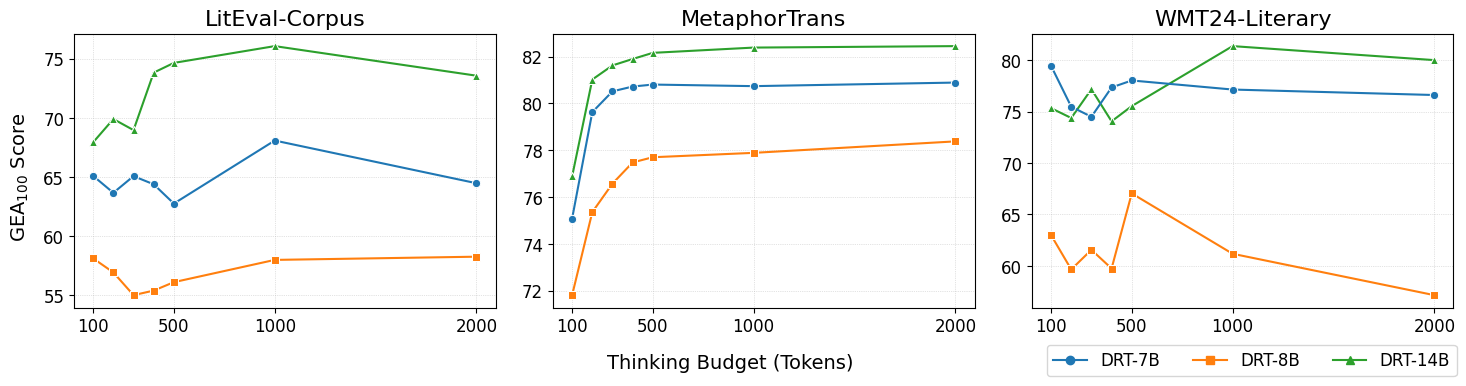

C:\Users\zihao\AppData\Local\Temp\ipykernel_25408\1111800195.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["budget"] = df["budget"].astype(int)


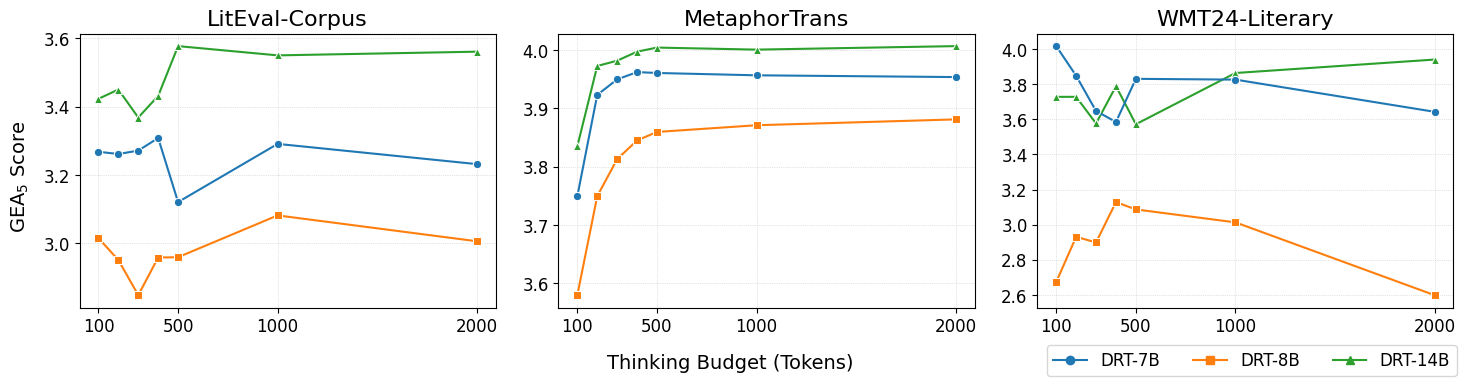

In [23]:
plot_scores(drt_gea_100_df, r"GEA$_{100}$", save_path="drt_gea100.png")
plot_scores(drt_gea_5_df, r"GEA$_{5}$", save_path="drt_gea5.png")